# Frozen Smoke Detection

**Purpose:** Document and finalize the process for identifying the frozen smoke in Qwen 3 4B's unembedding matrix.

---

## The Problem

Somewhere in the 151,936 × 2,560 unembedding matrix, there's an anomalous overdensity—thousands of tokens packed into a microscopic volume. We need a principled way to:

1. **Find** the overdensity (where is it?)
2. **Define** its boundaries (what's "in" vs "out"?)
3. **Extract** the member tokens for analysis

## Approach

We use **exponent space** as our primary coordinate system. In bfloat16, each value has an 8-bit exponent field. Two values are "nearby" if their exponents differ by at most some threshold.

**Why exponent space?** Because the overdensity spans multiple orders of magnitude in absolute value, but is coherent when viewed in terms of relative scale. Exponent space is scale-invariant.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file, save_file
from pathlib import Path

# Device detection
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

# Paths
DATA_DIR = Path("../../../tensors/Qwen3-4B-Instruct-2507")
OUTPUT_DIR = DATA_DIR

# Load unembedding matrix
W = load_file(DATA_DIR / "W_unembed.safetensors")['W'].view(torch.bfloat16)
print(f"Loaded W: {W.shape}")

Using device: mps
Loaded W: torch.Size([151936, 2560])


## Step 1: Find the Biggest Black Hole

A "black hole" is a point where multiple tokens share bit-for-bit identical embeddings. The biggest one is our anchor point.

In [2]:
# Find unique vectors and their counts
W_bits = W.view(torch.uint16).to(torch.int32)  # [151936, 2560]

unique_bits, inverse_indices, counts = torch.unique(
    W_bits, dim=0, return_inverse=True, return_counts=True
)

print(f"Total tokens: {len(W):,}")
print(f"Unique vectors: {len(unique_bits):,}")
print(f"Duplicates: {len(W) - len(unique_bits):,}")

# Find black holes (count > 1)
black_hole_mask = counts > 1
n_black_holes = black_hole_mask.sum().item()
black_hole_counts = counts[black_hole_mask]

print(f"\nBlack holes (vectors with multiple tokens): {n_black_holes}")
print(f"Black hole populations: {sorted(black_hole_counts.tolist(), reverse=True)}")

# The biggest black hole
biggest_bh_idx = counts.argmax().item()
biggest_bh_count = counts[biggest_bh_idx].item()

# Find one token that lives in the biggest black hole
biggest_bh_token = (inverse_indices == biggest_bh_idx).nonzero()[0].item()

print(f"\nBiggest black hole:")
print(f"  Unique vector index: {biggest_bh_idx}")
print(f"  Token count: {biggest_bh_count}")
print(f"  Example token index: {biggest_bh_token}")

Total tokens: 151,936
Unique vectors: 149,849
Duplicates: 2,087

Black holes (vectors with multiple tokens): 13
Black hole populations: [814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2]

Biggest black hole:
  Unique vector index: 12923
  Token count: 814
  Example token index: 80091


## Step 2: Define the Neighborhood in Exponent Space

We define "nearby" using L∞ distance in exponent space:

$$\text{dist}_{\text{exp}}(u, v) = \max_i |\text{exp}(u_i) - \text{exp}(v_i)|$$

where exp(x) extracts the 8-bit exponent field from a bfloat16 value.

**Threshold selection:** We sweep different thresholds and look for a natural boundary—a radius where the token count reaches a local minimum.

In [3]:
def get_exponents(tensor_bf16):
    """Extract 8-bit exponent field from bfloat16 values."""
    bits = tensor_bf16.view(torch.uint16).to(torch.int32)
    exponents = (bits >> 7) & 0xFF
    return exponents

# Get exponents for all tokens and the black hole center
W_exp = get_exponents(W)  # [151936, 2560]
center_exp = W_exp[biggest_bh_token]  # [2560]

# Compute L∞ distance in exponent space for all tokens
exp_diff = torch.abs(W_exp - center_exp)  # [151936, 2560]
exp_linf = exp_diff.max(dim=1).values  # [151936]

print(f"Exponent L∞ distance range: [{exp_linf.min().item()}, {exp_linf.max().item()}]")

Exponent L∞ distance range: [0, 29]


In [4]:
# Sweep thresholds and count tokens
max_threshold = 20
thresholds = list(range(max_threshold + 1))
token_counts = []

for t in thresholds:
    count = (exp_linf <= t).sum().item()
    token_counts.append(count)
    print(f"L∞ ≤ {t:2d}: {count:,} tokens")

# Find local minimum (the "waist" of the distribution)
for i in range(1, len(token_counts) - 1):
    if token_counts[i] < token_counts[i-1] and token_counts[i] <= token_counts[i+1]:
        print(f"\nLocal minimum at L∞ ≤ {thresholds[i]}: {token_counts[i]} tokens")

L∞ ≤  0: 2,139 tokens
L∞ ≤  1: 2,177 tokens
L∞ ≤  2: 2,195 tokens
L∞ ≤  3: 2,205 tokens
L∞ ≤  4: 2,211 tokens
L∞ ≤  5: 2,212 tokens
L∞ ≤  6: 2,215 tokens
L∞ ≤  7: 2,224 tokens
L∞ ≤  8: 2,237 tokens
L∞ ≤  9: 2,283 tokens
L∞ ≤ 10: 2,486 tokens
L∞ ≤ 11: 3,640 tokens
L∞ ≤ 12: 10,276 tokens
L∞ ≤ 13: 40,967 tokens
L∞ ≤ 14: 110,623 tokens
L∞ ≤ 15: 149,302 tokens
L∞ ≤ 16: 151,240 tokens
L∞ ≤ 17: 151,598 tokens
L∞ ≤ 18: 151,765 tokens
L∞ ≤ 19: 151,855 tokens
L∞ ≤ 20: 151,888 tokens


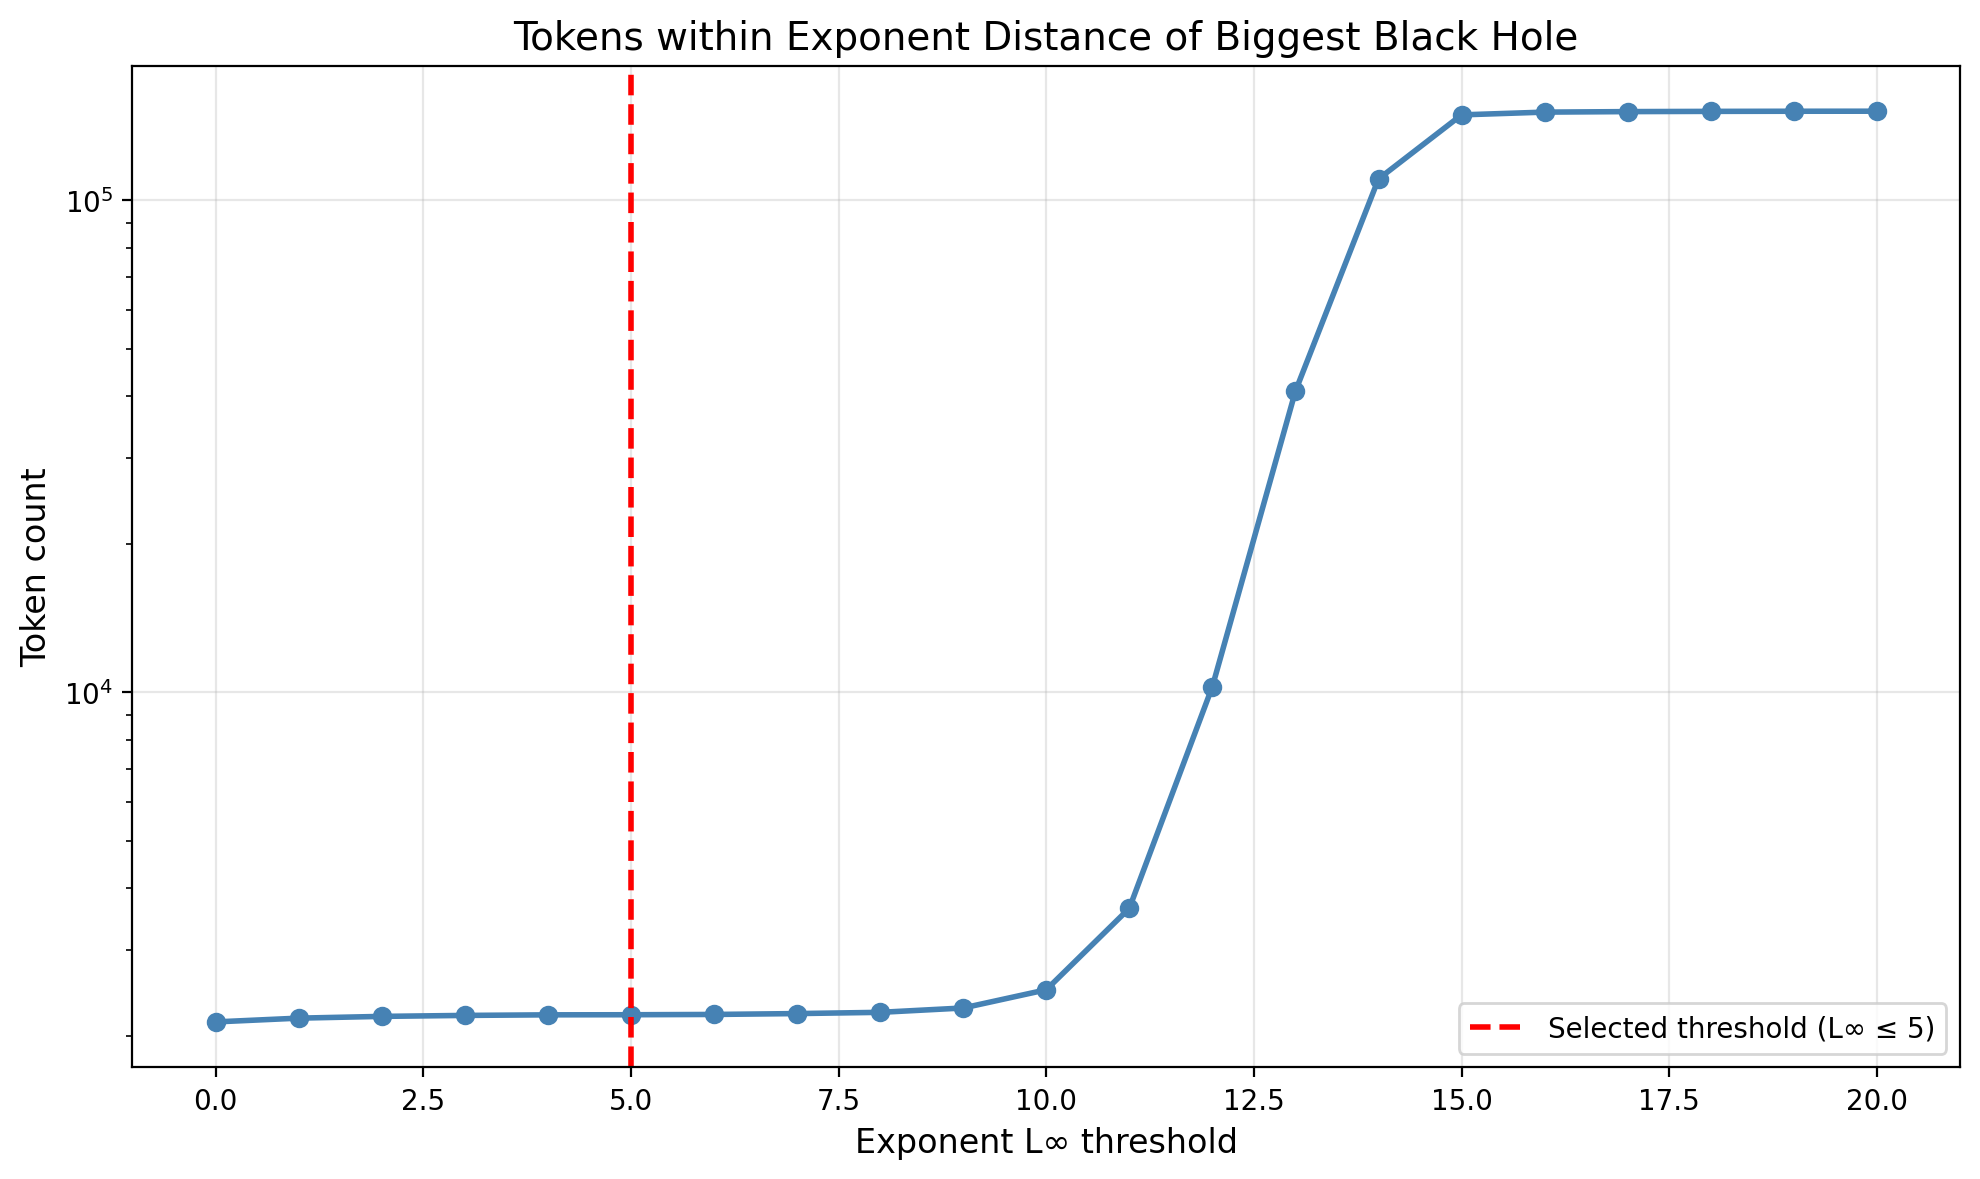

In [5]:
# Plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

ax.plot(thresholds, token_counts, 'o-', color='steelblue', linewidth=2, markersize=6)
ax.axvline(5, color='red', linestyle='--', linewidth=2, label='Selected threshold (L∞ ≤ 5)')

ax.set_xlabel('Exponent L∞ threshold', fontsize=12)
ax.set_ylabel('Token count', fontsize=12)
ax.set_title('Tokens within Exponent Distance of Biggest Black Hole', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.savefig('../../../notebooks/analysis/frozen_smoke_detection.png', dpi=200, bbox_inches='tight')
plt.show()

## Step 3: Finalize Selection

**Selected threshold: L∞ ≤ 5 exponents**

This captures the overdensity while excluding the main vocabulary cloud. The minimum at this threshold indicates a natural boundary.

In [6]:
MAX_EXP = 5

# Create neighborhood mask
neighborhood_mask = exp_linf <= MAX_EXP
n_neighborhood = neighborhood_mask.sum().item()

print(f"Selection criterion: L∞ ≤ {MAX_EXP} exponents from biggest black hole")
print(f"Tokens selected: {n_neighborhood:,}")
print(f"Fraction of vocabulary: {n_neighborhood / len(W) * 100:.2f}%")

Selection criterion: L∞ ≤ 5 exponents from biggest black hole
Tokens selected: 2,212
Fraction of vocabulary: 1.46%


In [7]:
# Save the mask for use in other notebooks
save_file(
    {'neighborhood_mask': neighborhood_mask},
    OUTPUT_DIR / 'masks.safetensors'
)
print(f"Saved neighborhood mask to {OUTPUT_DIR / 'masks.safetensors'}")

Saved neighborhood mask to ../../../tensors/Qwen3-4B-Instruct-2507/masks.safetensors


## Summary

**Detection process:**
1. Find the biggest black hole (vector with most duplicate tokens)
2. Compute L∞ distance in exponent space from all tokens to the black hole center
3. Select tokens within L∞ ≤ 5 exponents

**Result:**
- Center: Token 80091 (814 tokens at this position)
- Selection: 2,212 tokens
- Saved to: `masks.safetensors`